<a href="https://colab.research.google.com/github/KRiver28/TIL/blob/master/4_1_NPLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# A Neural Probabilistic Language Model (NPLM)
#
# NPLM 논문 : Yoshua Bengio, et. al., 2003, A Neural Probabilistic Language Model
# 코드 구현 : blog.naver.com/chunjein, 2021.03.22
# -------------------------------------------------------------------------------
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Add, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
data = ["The cat is walking in the bedroom",
        "A dog was running in a room",
        "The cat is running in a room",
        "A dog is walking in a bedroom",
        "The dog was walking in the room"]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
word2idx = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(data)
sequences

[[1, 8, 4, 5, 2, 1, 9],
 [3, 6, 10, 11, 2, 3, 7],
 [1, 8, 4, 11, 2, 3, 7],
 [3, 6, 4, 5, 2, 3, 9],
 [1, 6, 10, 5, 2, 1, 7]]

In [ ]:
# sequences 뒤에 <EOS>를 추가한다.
word2idx_len = len(word2idx)
word2idx['<PAD>'] = 0
word2idx['<EOS>'] = word2idx_len + 1  # end of sentence 추가
idx2word = {v: k for (k, v) in word2idx.items()}
sequences = [s + [word2idx['<EOS>']] for s in sequences]
sequences

[[1, 8, 4, 5, 2, 1, 9, 12],
 [3, 6, 10, 11, 2, 3, 7, 12],
 [1, 8, 4, 11, 2, 3, 7, 12],
 [3, 6, 4, 5, 2, 3, 9, 12],
 [1, 6, 10, 5, 2, 1, 7, 12]]

In [ ]:
def prepare_sentence(seq, maxlen):
    # Pads seq and slides windows
    x = []
    y = []
    for i, w in enumerate(seq[1:], 1):
        x.append(pad_sequences([seq[:i]], maxlen=maxlen - 1)[0])
        y.append(w)
    return x, y

In [ ]:
# 학습 데이터를 생성한다.
maxlen = max([len(s) for s in sequences])
x = []
y = []
for seq in sequences:
    x_, y_ = prepare_sentence(seq, maxlen)
    x += x_
    y += y_
    
x_train = np.array(x)
y_train = np.array(y)

x_train.shape, y_train.shape

((35, 7), (35,))

In [ ]:
x_train[:10]

array([[ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  8],
       [ 0,  0,  0,  0,  1,  8,  4],
       [ 0,  0,  0,  1,  8,  4,  5],
       [ 0,  0,  1,  8,  4,  5,  2],
       [ 0,  1,  8,  4,  5,  2,  1],
       [ 1,  8,  4,  5,  2,  1,  9],
       [ 0,  0,  0,  0,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  3,  6],
       [ 0,  0,  0,  0,  3,  6, 10]], dtype=int32)

In [ ]:
y_train[:10]

array([ 8,  4,  5,  2,  1,  9, 12,  6, 10, 11])

In [ ]:
# NPLM 모델을 생성한다.
EMB_SIZE = 8
VOCAB_SIZE = len(word2idx)
x_input = Input(batch_shape = (None, x_train.shape[1]))
x_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE, name='emb')(x_input)

# H-network
h_layer = Dense(10, activation='tanh')(x_embed)

# U-network
u_layer = Dense(10)(h_layer)

# W-network
w_layer = Dense(10)(x_embed)

# 전체 network
t_layer = Add()([u_layer, w_layer])
t_layer = Flatten()(t_layer)
y_output = Dense(VOCAB_SIZE, activation = 'softmax')(t_layer)

model = Model(x_input, y_output)     # 학습, 예측용 모델
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 emb (Embedding)                (None, 7, 8)         104         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 7, 10)        90          ['emb[0][0]']                    
                                                                                                  
 dense_1 (Dense)                (None, 7, 10)        110         ['dense[0][0]']                  
                                                                                              

In [ ]:
# 모델을 학습한다.
hist = model.fit(x_train, y_train, epochs=300, verbose=0)



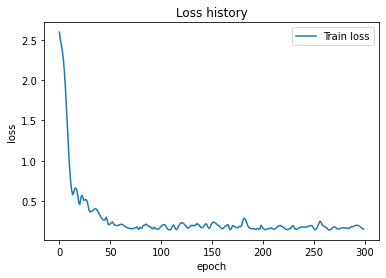

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
C = model.get_layer('emb').get_weights()[0]
C.shape

(13, 8)

In [ ]:
C[:7]

array([[-0.08973326, -0.04838462,  0.1061938 , -0.05840286,  0.04190561,
        -0.06975189, -0.08491569,  0.03442419],
       [-0.4407895 ,  0.32523194, -0.3825391 , -0.20935199, -0.4795784 ,
        -0.10192405, -0.05210585,  0.26958707],
       [ 0.24845757, -0.0589934 , -0.24025893, -0.09027704,  0.01829802,
         0.03883207,  0.31085908, -0.19956969],
       [ 0.05372076,  0.29036742, -0.11928943, -0.35584626, -0.21501687,
        -0.56064147,  0.30034524, -0.61866033],
       [ 0.10253561,  0.1964709 , -0.05675261, -0.17001858,  0.17024818,
         0.22311538, -0.29314086,  0.2971559 ],
       [ 0.15968458, -0.08156439, -0.10727007,  0.25984254,  0.0865691 ,
         0.48572117, -0.10320832,  0.5003195 ],
       [ 0.02342539, -0.10774957, -0.21366718,  0.1679461 , -0.0992263 ,
         0.4087033 , -0.28491166,  0.4058943 ]], dtype=float32)

In [ ]:
# 한 단어의 워드 벡터를 조회한다.
word = 'dog'
w_idx = word2idx[word]
wv = C[w_idx, :]  # look-up
print('\n단어 :', word)
print('인덱스 :', w_idx)
print(np.round(wv, 3))


단어 : dog
인덱스 : 6
[ 0.023 -0.108 -0.214  0.168 -0.099  0.409 -0.285  0.406]


In [ ]:
def get_prediction(model, sent):
    x = tokenizer.texts_to_sequences(sent)[0]
    x = pad_sequences([x], maxlen=maxlen - 1)[0]
    x = np.array(x).reshape(1, -1)
    return model.predict(x)[0]

In [ ]:
# 주어진 문장 다음에 나올 단어를 예측한다.
x_test = ['A dog is walking in a']
p = get_prediction(model, x_test)
n = np.argmax(p)
prob = p[n]
next_word = idx2word[n]
print("\n{} --> '{}', probability = {:.2f}%".format(x_test, next_word, prob * 100))


['A dog is walking in a'] --> 'bedroom', probability = 99.90%
